# 3D Gaussian Splatting for Real-Time Radiance Field Rendering (SIGGRAPH 2023)

arXiv - https://arxiv.org/abs/2308.04079

## 0. What is 3D Gaussian Splatting?

In page 4 of the paper,

> *We Choose 3D Gaussians, which are differentiable and can be easily projected to 2D Splats allowing fast alpha-blending or rendering.*

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/overview.JPG" alt="Overview of 3D Gaussian Splatting">
</div>

## 1. Preprocess the Dataset

### 1.1 Download the NeRF-synthetic Dataset

> The paper uses 3 datasets, NeRF-synthetic dataset, Mip-NeRF 360 dataset, and Tanks&Templates dataset.

We will start with NeRF-synthetic dataset that are easy to access.

In [2]:
from pathlib import Path
import gdown

# Setup dataset folder
dataset_path = Path("datasets/")

# Check if the dataset folder exists, and if not, download the dataset.
if dataset_path.is_dir():
  print(f"[INFO] {dataset_path} already exists.")
else:
  print(f"[INFO] Cannot find {dataset_path}, creating the directory...")
  dataset_path.mkdir(parents=True, exist_ok=True)

[INFO] Cannot find datasets, creating the directory...


In [3]:
!gdown "https://drive.google.com/uc?id=1OsiBs2udl32-1CqTXCitmov4NQCYdA9g" -O "./datasets/nerf_synthetic.zip"

Downloading...
From (original): https://drive.google.com/uc?id=1OsiBs2udl32-1CqTXCitmov4NQCYdA9g
From (redirected): https://drive.google.com/uc?id=1OsiBs2udl32-1CqTXCitmov4NQCYdA9g&confirm=t&uuid=fdcd447c-a1db-4ea6-b60d-60672b66219e
To: /content/datasets/nerf_synthetic.zip
100% 1.27G/1.27G [00:25<00:00, 50.2MB/s]


In [4]:
import zipfile

# Unzip NeRF_Synthetic dataset
with zipfile.ZipFile(dataset_path / "nerf_synthetic.zip", "r") as zip_ref:
  print("[INFO] Unzipping nerf_synthetic dataset...")
  zip_ref.extractall(dataset_path)

# Delete existing compressed dataset file
!rm "./datasets/nerf_synthetic.zip"

[INFO] Unzipping nerf_synthetic dataset...


### 1.2 Explore the NeRF-synthetic dataset

Stats:
+ 8 Scenes -  ***(chair, drums, ficus, hotdog, lego, materials, mic, ship)***
+ 100 Training images
+ 100 Validation images
+ 200 Test images
+ Images are 800x800

Structure:
  * SCENE_NAME
    * train
      * r_num.png
    * val
      * r_num.png
    * test
      * r_num.png
      * r_num_depth_0000.png
      * r_num_normal_0000.png
    * transforms_train.json
    * transforms_val.json
    * transforms_test.json

Transform json details:
  * camera_angle_x: The FOV in x dimension
  * frames: List of dictionaries that contain the camera transform matrices for each image.

Random image path: datasets/nerf_synthetic/mic/test/r_106_depth_0186.png
Image Height * Width : 800 * 800


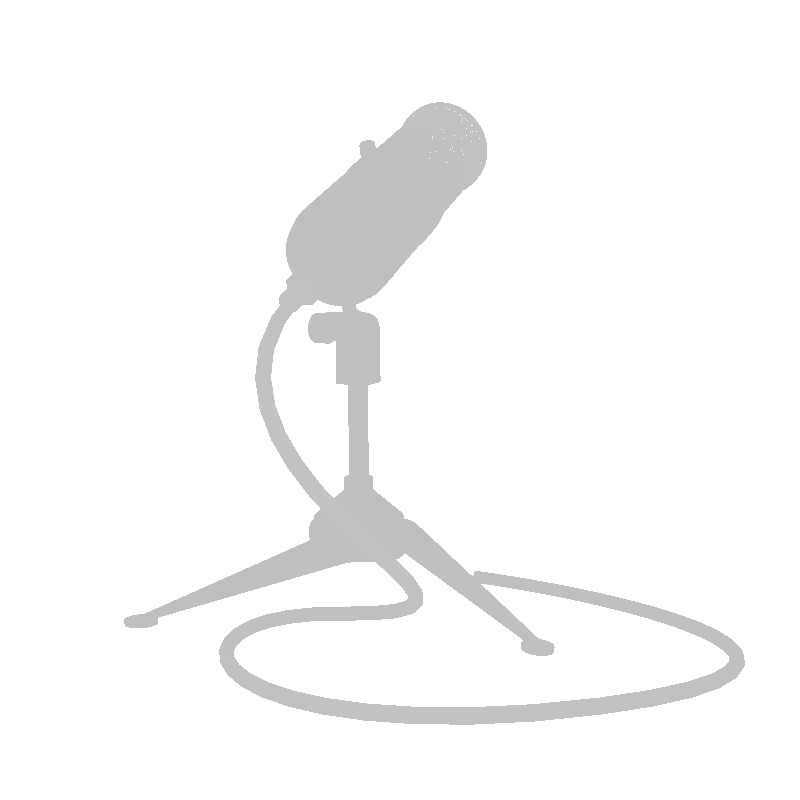

In [5]:
import random
from PIL import Image

# Get All Image Paths
nerf_synthetic_path = dataset_path / "nerf_synthetic"
image_path_list = list(nerf_synthetic_path.glob("*/*/*.png"))

# Get Random Image Path
random_image_path = random.choice(image_path_list)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image Height * Width : {img.height} * {img.width}")
img

### ***(Optional)*** 1.3 Make SfM (Structure-from-Motion) points from NeRF-synthetic dataset



**Note:** The below process takes a long time, so you can skip to **1.4 Download SfM points from HuggingFace**

In [6]:
!pip install pycolmap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 99.2 MB/s eta 0:00:00


```python
from pathlib import Path
import pycolmap
from pycolmap import logging
import shutil

def make_SfM_points(image_path: Path, category: str):
  """
  Args:
    image_path : pathlib.Path
    category : str - (e.g, chair, drums, ficus, hotdog, lego, materials, mic, ship)
  """
  output_path = Path("COLMAP/")
  category_path = output_path / category

  category_path.mkdir(parents=True, exist_ok=True)
  logging.set_log_destination(logging.INFO, output_path / "logs")

  database_path = category_path / "database.db"
  sfm_path = category_path / "sfm"

  print(f"[INFO] Processing category: {category}")
  if database_path.exists():
    database_path.unlink()

  pycolmap.extract_features(database_path, image_path)
  pycolmap.match_exhaustive(database_path)

  num_images = pycolmap.Database(database_path).num_images
  print(f"[INFO] Found {num_images} images in {category} dataset.")

  if sfm_path.exists():
    shutil.rmtree(sfm_path)
  sfm_path.mkdir(exist_ok=True)

  records = pycolmap.incremental_mapping(database_path, image_path, sfm_path)

  for idx, record in records.items():
    logging.info(f"#{idx} {record.summary}")

  print(f"[INFO] SfM completed for {category}.")
```

```python
categories = ["chair", "drums", "ficus", "hotdog", "lego", "materials", "mic", "ship"]

for category in categories:
  image_path = nerf_synthetic_path / category / "train"
  make_SfM_points(image_path, category)
```

### 1.4 Download SfM points from HuggingFace

- The dataset created in process 1.3 was uploaded to huggingface. - https://huggingface.co/datasets/pleasure97/NeRF_synthetic_SfM_Points

- Follow the below process and unzip the compressed file to a specified path.

In [7]:
!wget -q https://huggingface.co/datasets/pleasure97/NeRF_synthetic_SfM_Points/resolve/main/NeRF_synthetic_SfM_points.zip
!unzip -q NeRF_synthetic_SfM_points.zip -d COLMAP/
!rm -rf NeRF_synthetic_SfM_points.zip


### 1.5 Visualize SfM points from NeRF-synthetic dataset

In [8]:
!pip install -q open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.2 MB/s eta 0:00:00


In [9]:
from pathlib import Path
import pycolmap
import numpy as np
import open3d as o3d
import plotly.graph_objects as go

def create_SfM_points(sfm_path: Path):
  category = sfm_path.parent.stem
  reconstruction = pycolmap.Reconstruction(sfm_path)
  # Collect 3D points
  points = []
  colors = []

  for point3D in reconstruction.points3D.values():
    points.append(point3D.xyz)
    colors.append(point3D.color / 255.)

  points = np.array(points)
  colors = np.array(colors)

  print(f"[INFO] {category} points shape : {points.shape} | colors shape : {colors.shape}")

  return points, colors, category

def visualize_SfM_points(points, colors, category):
  """ Visualize the SfM points using Open3D.

  Args:
    points:
    colors:
    category:
  """
  # Create open3d point cloud
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(points)
  pcd.colors = o3d.utility.Vector3dVector(colors)

  # Visualize the point cloud
  print(f"[INFO] Visualizing {category} {len(points)} points...")

  fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2],
            mode='markers',
            marker=dict(size=1, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
  )
  fig.show()

In [10]:
import random
categories = ["chair", "drums", "ficus", "hotdog", "lego", "materials", "mic", "ship"]
use_random = False
if use_random:
  selected_category = random.choice(categories)
  sfm_path = Path("COLMAP/") / selected_category / Path("sfm/0")
else:
  sfm_path = Path("COLMAP/hotdog/sfm/0")
points, colors, category = create_SfM_points(sfm_path)
visualize_SfM_points(points, colors, category)

[INFO] sfm points shape : (8261, 3) | colors shape : (8261, 3)
[INFO] Visualizing sfm 8261 points...


You can visualize point clouds like this:

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/SfM Points.png" alt="SfM Points">
</div>

## 2. Initialization




### 2.1 Create a set of 3D Gaussians

In page 4 of the paper,

*From these points we create a set of 3D Gaussians defined by a position (mean), covariance matrix and opacity $\alpha$*

*Our Gaussians are defined by a full 3D covariance matrix $\Sigma$ defined in world space centered at point (mean) $\mu$*

$$ G(x)=e^{-\frac{1}{2}(x)^T \Sigma^{-1}(x)}$$



In [11]:
from pathlib import Path
import numpy as np
from scipy.stats import multivariate_normal
from typing import Dict
import plotly.graph_objects as go


def create_3D_Gaussians(points, colors, grid_size:int=100) -> Dict[str, np.array]:
  """ Create a set of 3D Gausssians.

  Args:
    sfm_path: Path to the SfM folder containing the COLMAP outputs.
  """

  points, colors, _ = create_SfM_points(sfm_path)

  # Calculate the mean
  mu = np.mean(points, axis=0)

  # Calculate the covariance matrix
  covariance_matrix = np.cov(points, rowvar=False)

  # Define the grid range
  x_range = np.linspace(points[:, 0].min(), points[:, 0].max(), grid_size)
  y_range = np.linspace(points[:, 1].min(), points[:, 1].max(), grid_size)
  z_range = np.linspace(points[:, 2].min(), points[:, 2].max(), grid_size)

  # Create a 3D grid
  x, y, z = np.meshgrid(x_range, y_range, z_range)
  grid_points = np.stack([x.ravel(), y.ravel(), z.ravel()], axis=1)

  # Create a multivariate Gaussian distribution
  gaussian = multivariate_normal(mean=mu, cov=covariance_matrix)

  # Reshape PDF values to match the grid
  pdf_values = gaussian.pdf(grid_points).reshape(x.shape)

  return  {
      "pdf_values": pdf_values,
      "x_range": x_range,
      "y_range": y_range,
      "z_range": z_range
  }

def visualize_3D_Gaussians(data: Dict[str, np.array]):

  pdf_values = data["pdf_values"]
  x_range = data["x_range"]
  y_range = data["y_range"]
  z_range = data["z_range"]

  # Generate Plotly Volume plot
  fig = go.Figure(data=go.Volume(
      x=np.repeat(x_range, len(y_range) * len(z_range)),
      y=np.tile(np.repeat(y_range, len(z_range)), len(x_range)),
      z=np.tile(z_range, len(x_range) * len(y_range)),
      value=pdf_values.ravel(),
      isomin=pdf_values.min(),
      isomax=pdf_values.max(),
      opacity=0.1,
      surface_count=10,
      colorscale="Viridis"
  ))

  # Setup plot
  fig.update_layout(
      scene=dict(
          xaxis_title="X",
          yaxis_title="Y",
          zaxis_title="Z",
          aspectmode="cube"
      ),
      title="3D Gaussian Visualization"
  )

  fig.show()

In [12]:
gaussian_data = create_3D_Gaussians(points, colors)
# visualize_3D_Gaussians(gaussian_data)

[INFO] sfm points shape : (8261, 3) | colors shape : (8261, 3)


You can visualize the 3D Gaussian like this:

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/3D Gaussian.png" alt="3D Gaussian">
</div>

## 3. Projection




### 3.1 Operation Flow of Projection

In page 4 of the paper,
* $W$ - Viewing transform matrix
* $J$ - Jacobian of the affine approximation of the projective transform
* $\Sigma^{\prime}$ - Covariance matrix in view space

$$ \Sigma^{\prime}=J W \Sigma W^T J^T $$

* $\Sigma$ - Covariance matrix in world space

**Note**: $\Sigma$ has physical meaning only when they are positive semi-definite.


$$ \Sigma=R S S^T R^T$$

* $R$ - Rotation matrix
  * $q$ - a quaternion to represent rotation
* $S$ - Scaling matrix
  * $s$ - a 3D vector for scaling

**Note:** To update the parameters of the covariance matrix using gradient descent, the optimized representation above was adopted to ensure that the covariance matrix remains positive semi-definite.

---
Now we need to use **PyTorch**.

In [13]:
# Make device-agnostic code in PyTorch
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
q = torch.nn.Parameter(data=torch.randn((1, 4))).to(device)

print(f"q in device : {q.device}")
print(f"q shape : {q.shape}")

q in device : cuda:0
q shape : torch.Size([1, 4])


<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/equation 10.JPG" alt="Quaternion to Rotation Matrix">
</div>

In [17]:
from scipy.spatial import KDTree
import torch
import numpy as np

def distCUDA2(points: np.ndarray, device: torch.device=device):
  """
    Calculates the average squared distance to the 3 nearest neighbors
    for each point in a point cloud using a KDTree.

    Args:
        points (np.ndarray): Input point cloud with shape (N, 3),
            where N is the number of points, and each point has 3 coordinates (x, y, z).
        device (torch.device, optional): The target device (e.g., 'cuda' or 'cpu')
            where the resulting tensor will be stored. Defaults to `device`.

    Returns:
        torch.Tensor: A 1D tensor of shape (N,) containing the average squared distances
            to the 3 nearest neighbors for each point.

  Notes:
    In source code, they use `from simple_knn._C import distCUDA2`.
    This version re-implements the functionality purely using PyTorch and SciPy,
          based on a solution by @rfeinman (see https://github.com/graphdeco-inria/gaussian-splatting/issues/292).
  """
  dists, indices = KDTree(points).query(points, k=4)
  meanDists = (dists[:, 1:] ** 2).mean(1)

  return torch.tensor(meanDists, device=device)

In [18]:
import torch
import numpy as np

def make_rotation_matrix(q: torch.Tensor, device: torch.device=device) -> torch.Tensor:
  """
  Args:
    q - quaternion, a tensor with shape (1, 4)
    device - torch.device, "cuda" or "cpu"
  Returns:
    R - Rotation matrix, a tensor with shape (3, 3)
  """
  q_r, q_i, q_j, q_k = q[:, 0], q[:, 1], q[:, 2], q[:, 3]

  if device == "cuda":
    R = torch.zeros((3, 3), device="cuda")
  elif device == "cpu":
    R = torch.zeros((3, 3), device="cpu")

  R[0, 0] = 1 - 2 * (q_j ** 2 + q_k ** 2)
  R[1, 1] = 1 - 2 * (q_i ** 2 + q_k ** 2)
  R[2, 2] = 1 - 2 * (q_i ** 2 + q_j ** 2)

  R[0, 1] = 2 * (q_i * q_j - q_r * q_k)
  R[1, 0] = 2 * (q_i * q_j + q_r * q_k)

  R[0, 2] = 2 * (q_i * q_k + q_r * q_j)
  R[2, 0] = 2 * (q_i * q_k - q_r * q_j)

  R[1, 2] = 2 * (q_j * q_k - q_r * q_i)
  R[2, 1] = 2 * (q_j * q_k + q_r * q_i)

  return R

def make_scaling_matrix(points: np.array, device: torch.device=device) -> torch.Tensor:
  """
  Args:
    points - derived from SfM point cloud, should be in CUDA
    device - torch.device, "cuda" or "cpu"
  Returns:
    S - Scaling matrix, a tensor with shape (3, 3)

  """

  points_distances = torch.clamp(distCUDA2(points).float().to(device), min=1e-7)
  print(f"points_distances shape : {points_distances.shape}")

  scale_factors = torch.log(torch.sqrt(points_distances)).mean(dim=0)

  S = torch.full((3, 3), scale_factors, device=device)
  print(f"S shape : {S.shape}")
  return S

def calc_covariance_matrix (R : torch.Tensor, S: torch.Tensor) -> torch.Tensor:
  """
  Args:
    R - Rotation matrix, a tensor with shape (3, 3)
    S - Scaling matrix, a tensor with shape (3, 3)
  Returns:
    SIGMA - Covariance matrix, a tensor with shape (3, 3)
  """

  RS = (R @ S)
  SIGMA = RS @ RS.T

  return SIGMA

In [19]:
R = make_rotation_matrix(q)

S = make_scaling_matrix(points)

print(S)
print(S.shape)

points_distances shape : torch.Size([8261])
S shape : torch.Size([3, 3])
tensor([[-4.0898, -4.0898, -4.0898],
        [-4.0898, -4.0898, -4.0898],
        [-4.0898, -4.0898, -4.0898]], device='cuda:0')
torch.Size([3, 3])


### 3.2 Create a Gaussian Model

In order to implement the operation flow and gradient flow of the paper,

a model which can perform forward and backward operations is needed.

---

In page 13 of the paper,

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/algorithm 1-1.JPG" alt="Algorithm 1-1">
</div>


In [20]:
import torch

def inverse_sigmoid(x: torch.Tensor):
  return torch.log(x / (1-x))

In [53]:
from torch import nn
import numpy as np

class GaussianSplattingModelV1(nn.Module):
  def __init__(self, points, colors):

    super().__init__()

    points_to_tensor, features_diffuse_color, features_rest, quaternions, scaling_vectors, opacities = self.initialize_from_gaussians(points, colors)

    self.xyz = nn.Parameter(points_to_tensor, requires_grad=True)
    self.features_diffuse_color = nn.Parameter(features_diffuse_color, requires_grad=True)
    self.features_rest = nn.Parameter(features_rest, requires_grad=True)
    self.quaternions = nn.Parameter(quaternions, requires_grad=True)
    self.scaling_vectors = nn.Parameter(scaling_vectors, requires_grad=True)
    self.opacities = nn.Parameter(opacities, requires_grad=True)

    # self.update_covariances()

  def update_covariances(self):
    self.covariances = calc_covariance_matrix(make_rotation_matrix(self.quaternions), make_scaling_matrix(self.scaling_vectors))

  def initialize_from_gaussians(self, points, colors, max_sh_degree=3, C0=0.28209479177387814):
    # Conver numpy array of points to torch.Tensor
    points_to_tensor = torch.tensor(np.asarray(points), device=device)

    # Conver numpy array of colors to torch.Tensor and simultaneously convert RGB to Spherical Harmonics coefficients.
    colors_to_SH = (torch.tensor(np.asarray(colors), device=device) - 0.5) / C0
    features = torch.zeros((colors_to_SH.shape[0],  3, (max_sh_degree + 1) ** 2), device=device)

    features[:, :3, 0] = colors_to_SH
    features[:, 3:, 1:] = 0.

    features_diffuse_color = features[:, :, 0:1].transpose(1, 2).contiguous()
    features_rest = features[:, :, 1:].transpose(1, 2).contiguous()

    quaternions = torch.zeros((points_to_tensor.shape[0], 4), device=device)
    quaternions[:, 0] = 1

    distances = torch.clamp_min(distCUDA2(points), 1e-7)
    scaling_vectors = torch.log(torch.sqrt(distances)).unsqueeze(-1).expand(-1, 3)

    opacities = inverse_sigmoid(0.1 * torch.ones((points_to_tensor.shape[0], 1), device=device))

    return points_to_tensor, features_diffuse_color, features_rest, quaternions, scaling_vectors, opacities

  def print_model_parameters(self):
    print(f"{'Parameter Name':<30} {'Shape':<30} {'Trainable':<10}")
    print("-" * 70)
    for name, param in self.named_parameters():
        print(f"{name:<30} {str(list(param.shape)):<30} {param.requires_grad}")

  def forward(self, x:torch.Tensor):
    return self.xyz, self.features_diffuse_color, self.features_rest, self.quaternions, self.scaling_vectors, self.opacities

In [55]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

GSM_V1 = GaussianSplattingModelV1(points=points,
                                  colors=colors)

summary(model=GSM_V1,
        input_size=points.shape,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
GaussianSplattingModelV1 (GaussianSplattingModelV1)     [8261, 3]            [8261, 3]            487,399              True
Total params: 487,399
Trainable params: 487,399
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.10
Forward/backward pass size (MB): 0.40
Params size (MB): 2.15
Estimated Total Size (MB): 2.64

In [56]:
GSM_V1.print_model_parameters()

Parameter Name                 Shape                          Trainable 
----------------------------------------------------------------------
xyz                            [8261, 3]                      True
features_diffuse_color         [8261, 1, 3]                   True
features_rest                  [8261, 15, 3]                  True
quaternions                    [8261, 4]                      True
scaling_vectors                [8261, 3]                      True
opacities                      [8261, 1]                      True


### 3.3 Optimization

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/equation 7.JPG" alt="Loss Equation">
</div>

In [ ]:
import torch
from math import exp
import torch.nn.functional as F

def gaussian(window_size: int,
             sigma: float):
  """
  Generates a list of Tensor values drawn from a gaussian distribution with standard deviation.
  """
  gauss = torch.Tensor([exp(-(x - window_size // 2) **2 / float(2 * sigma ** 2)) for x in range(window_size)])
  return gauss / gauss.sum()

def create_window(window_size: int,
                  channel: int=1):

  # _1d_window : (window_size, 1)
  _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)

  # _2d_window : (window_size, window_size)
  _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)

  # window : (channel, 1, window_size, window_size)
  window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())

  return window

def ssim(img1, img2, window_size=11, size_average=True):

  try:
    _, channel, height, width = img1.size()
  except:
    channel, height, width = img1.size()

  window = create_window(window_size=window_size, channel=channel)

  if img1.is_cuda:
    window = window.cuda(img1.get_device())
  window = window.type_as(img1)

  mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
  mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

  sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1.pow(2)
  sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2.pow(2)
  sigma_1_2 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu_1 * mu_2

  C1, C2 = 0.01 **2, 0.03 ** 2

  ssim_map = ((2 * mu1 * mu2 + C1) * (2 * sigma_1_2 + C2)) / ((mu1.pow(2) + mu2.pow(2) + C1) * (sigma1_sq + sigma2_sq + C2))

  if size_average:
    return ssim_map.mean()
  else:
    return ssim_map.mean(1).mean(1).mean(1)

In [ ]:
LAMBDA = 0.2 # hyperparameter of the loss

#
loss = (1 - LAMBDA) * torch.nn.L1Loss(pred_image, src_image) + LAMBDA * ssim(pred_image, src_image)

### 3.4 Adaptive Density Control

In [ ]:
GSM = GaussainSplattingModelV1(points=,
                       q=,
                       s=,
                       c=,
                       alpha=)



optimizer = torch.optim.Adam(params=GSM.parameters())


# Forward Pass
  GSM()

# Calculate the loss
  loss

# Optimizer zero grad
  optimizer.zero_grad()

# Loss backward
  loss.backward()

# Optimizer step
  optimizer.step()

## References

* Source Code - https://github.com/graphdeco-inria/gaussian-splatting

* Dataset - https://xoft.tistory.com/44

* Paper Review - https://xoft.tistory.com/51

* distCUDA2 - https://github.com/graphdeco-inria/gaussian-splatting/issues/292

* SSIM - https://gaussian37.github.io/vision-concept-ssim/